# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

Loading training data...
Found 1695 files belonging to 4 classes.
Loading validation data...
Found 502 files belonging to 4 classes.

Found 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of training batches: 53
Number of validation batches: 16

Normalized Image batch min value: 0.0
Normalized Image batch max value: 1.0


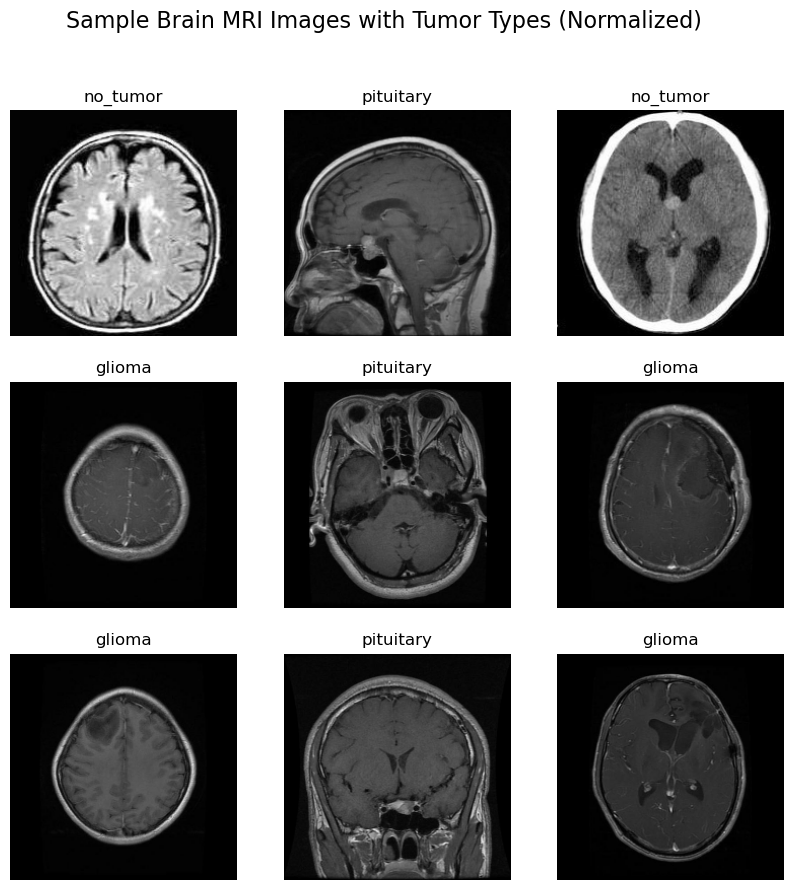

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the base path to your dataset
base_data_dir = r'C:\Users\sudhi\PycharmProjects\Python\MRI Classification'

# Define paths for training and validation data
train_data_dir = os.path.join(base_data_dir, 'train')
val_data_dir = os.path.join(base_data_dir, 'valid')

# Define image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Load the training dataset
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Use categorical for one-hot encoded labels
)

# Load the validation dataset
print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Use categorical for one-hot encoded labels
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes: {class_names}")
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

# --- Normalization Layer ---
# All pixel values will be normalized to the [0, 1] range.
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to both datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Verify normalization (optional)
for image_batch, labels_batch in normalized_train_ds.take(1):
    print(f"\nNormalized Image batch min value: {np.min(image_batch.numpy())}")
    print(f"Normalized Image batch max value: {np.max(image_batch.numpy())}")
    break

# --- Visualize some images from the dataset ---
plt.figure(figsize=(10, 10))
for images, labels_one_hot in normalized_train_ds.take(1):
    for i in range(min(9, BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        predicted_class_index = np.argmax(labels_one_hot[i].numpy())
        plt.title(class_names[predicted_class_index])
        plt.axis("off")
plt.suptitle("Sample Brain MRI Images with Tumor Types (Normalized)", fontsize=16)
plt.show()

In [4]:
# Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2)
])

# Apply data augmentation to the normalized training dataset
augmented_train_ds = normalized_train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configure datasets for performance using caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE

final_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
final_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nData loading, preprocessing, and augmentation complete!")
print(f"Final training dataset ready: {type(final_train_ds)}")
print(f"Final validation dataset ready: {type(final_val_ds)}")
print(f"Number of classes: {num_classes}")


Data loading, preprocessing, and augmentation complete!
Final training dataset ready: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Final validation dataset ready: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Number of classes: 4


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define image dimensions and number of classes from previous steps
IMG_HEIGHT = 224
IMG_WIDTH = 224
num_classes = 4 # 4 classes: Glioma, Meningioma, No Tumor, Pituitary

def build_custom_cnn_model():
    model = models.Sequential([
        # Input layer expects images of shape (IMG_HEIGHT, IMG_WIDTH, 3)
        # We don't need a Rescaling layer here if we already normalized in the data pipeline
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(), # Flatten the 3D output to 1D vector

        layers.Dense(128, activation='relu'), # Fully connected layer
        layers.Dropout(0.5), # Add dropout for regularization to prevent overfitting

        layers.Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
    ])
    return model

# Create an instance of your custom CNN model
custom_cnn_model = build_custom_cnn_model()

# Print the model summary to see the architecture and number of parameters
custom_cnn_model.summary()

C:\Users\sudhi\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model
custom_cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nCustom CNN model compiled successfully!")


Custom CNN model compiled successfully!


In [7]:
# Define the number of training epochs
EPOCHS = 15 # You can adjust this number based on model performance

print(f"\nStarting training for {EPOCHS} epochs...")

history = custom_cnn_model.fit(
    final_train_ds,
    validation_data=final_val_ds,
    epochs=EPOCHS
)

print("\nTraining complete!")


Starting training for 15 epochs...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 422ms/step - accuracy: 0.4301 - loss: 1.5559 - val_accuracy: 0.6016 - val_loss: 0.9534
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 393ms/step - accuracy: 0.6616 - loss: 0.8691 - val_accuracy: 0.7131 - val_loss: 0.7798
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - accuracy: 0.7461 - loss: 0.6618 - val_accuracy: 0.7689 - val_loss: 0.6263
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8007 - loss: 0.5305 - val_accuracy: 0.7809 - val_loss: 0.6378
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.8229 - loss: 0.4630 - val_accuracy: 0.8386 - val_loss: 0.4667
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 425ms/step - accuracy: 0.8620 - loss: 0.3493 - val_accuracy: 0.8207 - val_loss: 0.4796
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.8750 - loss: 0.3356 - val_accuracy: 0.7908 - val_loss: 0.6221
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accura


Evaluating the model on the validation dataset...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7596 - loss: 1.0221
Validation Loss: 1.0107
Validation Accuracy: 0.7550


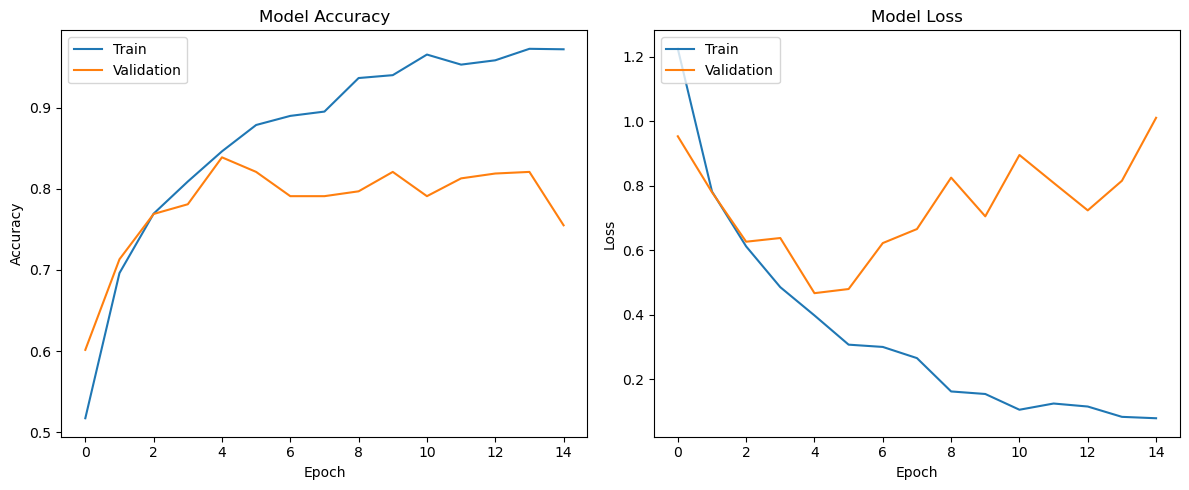


Custom CNN model training and evaluation complete. Review the plots to assess performance.


In [8]:
# Evaluate the model on the validation set
print("\nEvaluating the model on the validation dataset...")
loss, accuracy = custom_cnn_model.evaluate(final_val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

print("\nCustom CNN model training and evaluation complete. Review the plots to assess performance.")

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os

# Define image dimensions and number of classes
IMG_HEIGHT = 224
IMG_WIDTH = 224
num_classes = 4 # Glioma, Meningioma, No Tumor, Pituitary

# Base directory for your data
base_data_dir = r'C:\Users\sudhi\PycharmProjects\Python\MRI Classification'
train_data_dir = os.path.join(base_data_dir, 'train')
val_data_dir = os.path.join(base_data_dir, 'valid')
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Data Loading and Preprocessing (Ensure these are set up as before) ---
# If you are running this in a new session, you'll need to re-execute the data loading and augmentation steps
# from the previous "Data Loading and Preprocessing" section.

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2)
])
augmented_train_ds = normalized_train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)

final_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
final_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipelines (final_train_ds, final_val_ds) ready for transfer learning.")

# Build the Transfer Learning model
def build_transfer_learning_model(input_shape, num_classes):
    # Load MobileNetV2 pre-trained on ImageNet, excluding its top classification layer
    base_model = applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model to prevent its weights from being updated during initial training
    base_model.trainable = False

    # Create the model by adding new classification layers on top of the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False) # Important: set training=False when using frozen layers
    x = layers.GlobalAveragePooling2D()(x) # Global average pooling to flatten the features
    x = layers.Dense(128, activation='relu')(x) # A new dense layer for classification
    x = layers.Dropout(0.5)(x) # Dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x) # Output layer with softmax

    model = models.Model(inputs, outputs)
    return model

# Create an instance of the transfer learning model
transfer_learning_model = build_transfer_learning_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=num_classes
)

print("\n--- Transfer Learning Model Architecture (Base frozen) ---")
transfer_learning_model.summary()

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Data pipelines (final_train_ds, final_val_ds) ready for transfer learning.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Transfer Learning Model Architecture (Base frozen) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Standard learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model's new layers
print("\n--- Training only the new classification layers (head) ---")
initial_epochs = 10 # Train for a few epochs
history_head = transfer_learning_model.fit(
    final_train_ds,
    validation_data=final_val_ds,
    epochs=initial_epochs
)

print("\nInitial training of classification head complete!")


--- Training only the new classification layers (head) ---
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step - accuracy: 0.5846 - loss: 1.0784 - val_accuracy: 0.7749 - val_loss: 0.5664
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - accuracy: 0.8234 - loss: 0.4805 - val_accuracy: 0.8147 - val_loss: 0.4687
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - accuracy: 0.8409 - loss: 0.4015 - val_accuracy: 0.8187 - val_loss: 0.4907
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8861 - loss: 0.3244 - val_accuracy: 0.8147 - val_loss: 0.5212
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8742 - loss: 0.3052 - val_accuracy: 0.8327 - val_loss: 0.4825
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 420ms/step - accuracy: 0.9007 - loss: 0.2698 - val_accuracy: 0.8486 - val_loss: 0.4464
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.9098 - loss: 0.2670 - val_accuracy: 0.8386 - val_loss: 0.4653
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━

In [11]:
print("\n--- Starting Fine-tuning Phase ---")

# Unfreeze the base model
base_model = transfer_learning_model.layers[1] # Get the MobileNetV2 base model layer
base_model.trainable = True

# Fine-tune from a specific layer onwards. For MobileNetV2, a layer around 100-150 is often suitable.
# Freezing layers before `fine_tune_at` helps preserve general features.
fine_tune_at = 100 # You can experiment with this number

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a much lower learning rate for fine-tuning
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Very small learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\n--- Transfer Learning Model Architecture (with some base layers unfrozen) ---")
transfer_learning_model.summary()

# Continue training for additional epochs
fine_tune_epochs = 10 # Additional epochs for fine-tuning
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_learning_model.fit(
    final_train_ds,
    validation_data=final_val_ds,
    epochs=total_epochs,
    initial_epoch=history_head.epoch[-1] + 1 # Start from where initial training left off
)

print("\nFine-tuning complete!")


--- Starting Fine-tuning Phase ---

--- Transfer Learning Model Architecture (with some base layers unfrozen) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,025,924 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 715ms/step - accuracy: 0.7012 - loss: 1.2558 - val_accuracy: 0.8805 - val_loss: 0.4313
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 651ms/step - accuracy: 0.9417 - loss: 0.1606 - val_accuracy: 0.8944 - val_loss: 0.5033
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9814 - loss: 0.0558 - val_accuracy: 0.8745 - val_loss: 0.5150
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 661ms/step - accuracy: 0.9957 - loss: 0.0185 - val_accuracy: 0.8586 - val_loss: 0.5773
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.9962 - loss: 0.0124 - val_accuracy: 0.8606 - val_loss: 0.5706
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 854ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.8586 - val_loss: 0.6159
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.8606 - val_loss: 0.6586
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - accuracy: 1.0000 - loss: 0.0020 - val


Evaluating the fine-tuned transfer learning model on the validation dataset...
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.8540 - loss: 0.8717
Final Validation Loss: 0.7070
Final Validation Accuracy: 0.8625


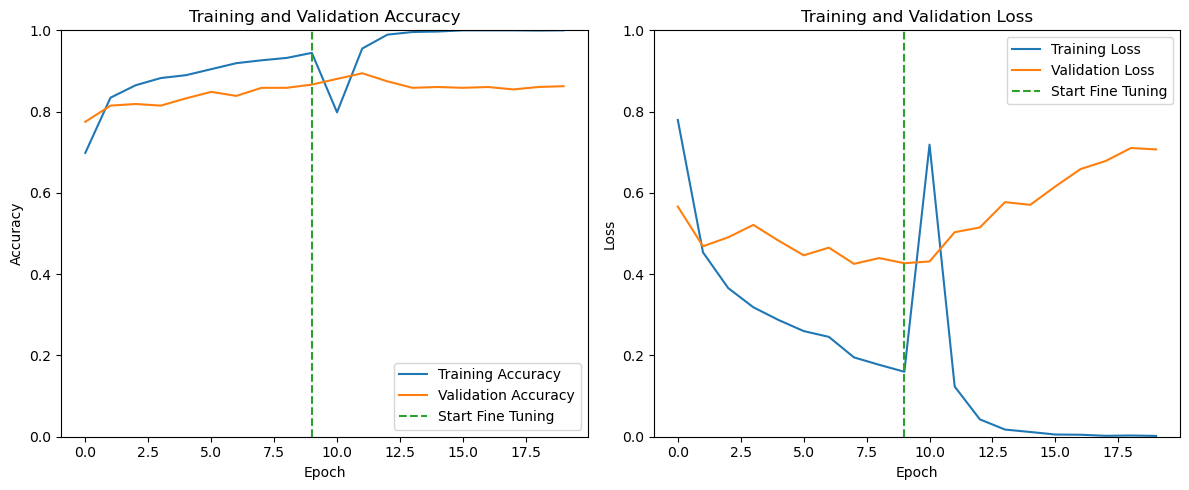


Transfer Learning model training and evaluation complete. Review the plots to assess performance.


In [12]:
# Combine history objects for plotting
acc = history_head.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history_head.history['val_accuracy'] + history_fine_tune.history['val_accuracy']

loss = history_head.history['loss'] + history_fine_tune.history['loss']
val_loss = history_head.history['val_loss'] + history_fine_tune.history['val_loss']

# Evaluate the fine-tuned model on the validation dataset
print("\nEvaluating the fine-tuned transfer learning model on the validation dataset...")
final_loss, final_accuracy = transfer_learning_model.evaluate(final_val_ds)
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# Plotting combined training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\nTransfer Learning model training and evaluation complete. Review the plots to assess performance.")

In [18]:
model_to_save = transfer_learning_model # Or custom_cnn_model
model_save_path = './saved_model/my_brain_mri_model.keras' # Add .keras extension
model_to_save.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: ./saved_model/my_brain_mri_model.keras


In [19]:
import os
# Assuming 'transfer_learning_model' is your best performing trained model
# If your custom CNN was better, use 'custom_cnn_model' instead.
model_to_save = transfer_learning_model

# Define the directory to save the model
model_save_dir = './saved_model'
# Create the directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

# Define the full path for saving the model file with the .keras extension
model_save_path = os.path.join(model_save_dir, 'my_brain_mri_model.keras')

# Save the model
model_to_save.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: ./saved_model\my_brain_mri_model.keras
